In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as pt

#load the dataset
batch_array = [128, 512]
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
training_set = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = trans)
testing_set = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = trans)

train_loader_1 = torch.utils.data.DataLoader(training_set, batch_size=batch_array[0], shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(testing_set, batch_size=batch_array[0], shuffle=False)

train_loader_2 = torch.utils.data.DataLoader(training_set, batch_size=batch_array[1], shuffle=True)
test_loader_2 = torch.utils.data.DataLoader(testing_set, batch_size=batch_array[1], shuffle=False)

In [3]:
#Constructing the Neural Network Model
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

In [4]:
def train_and_test_model(model, optimizer, trainloader, testloader, loss_function):
    model.train()
    compute_train_losses, compute_test_losses = [], []
    compute_train_accuracy, compute_test_accuracy = [], []
    epoch = 0
    epochs = 15
    while epoch < epochs:
        total_train_loss = 0.0
        correct = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            loss = loss_function(predicted_outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            predicted = predicted_outputs.argmax(dim=1)
            total = predicted.eq(labels.view_as(predicted))
            correct += total.sum().item()
            
        train_loss = (total_train_loss / len(trainloader))
        compute_train_losses.append(train_loss)
        compute_train_accuracy.append((correct / len(trainloader.dataset)))
        
        model.eval()
        total_test_loss = 0.0
        actual = 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                predicted_outputs = model(inputs)
                total_test_loss += loss_function(predicted_outputs, labels).item()
                predicted = predicted_outputs.argmax(dim=1)
                total = predicted.eq(labels.view_as(predicted))
                actual += total.sum().item()
                
        test_loss = (total_test_loss / len(testloader))
        compute_test_losses.append(test_loss)
        compute_test_accuracy.append((actual / len(testloader.dataset)))
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}')
        epoch +=1
    return compute_train_losses, compute_test_losses, compute_train_accuracy, compute_test_accuracy

In [5]:
loss_function = nn.CrossEntropyLoss()
model1 = Model_1()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
batch1_train_loss, batch1_test_loss, batch1_train_acc, batch1_test_acc = train_and_test_model(model1, optimizer1, train_loader_1, test_loader_1, loss_function)


model2 = Model_1()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
batch2_train_loss, batch2_test_loss, batch2_train_acc, batch2_test_acc = train_and_test_model(model2, optimizer2, train_loader_2, test_loader_2, loss_function)

Epoch: 1, Train Loss: 0.28262206608616214, Test Loss: 0.08844993771879073
Epoch: 2, Train Loss: 0.07600055372457641, Test Loss: 0.05385373285500026
Epoch: 3, Train Loss: 0.05330274513225629, Test Loss: 0.04778244655838684
Epoch: 4, Train Loss: 0.04153887135163347, Test Loss: 0.04127955021295414
Epoch: 5, Train Loss: 0.034244945378048716, Test Loss: 0.03402343895693407
Epoch: 6, Train Loss: 0.02868249041484053, Test Loss: 0.03889826417545481
Epoch: 7, Train Loss: 0.02349997498417722, Test Loss: 0.04102428506689936
Epoch: 8, Train Loss: 0.01943190109534765, Test Loss: 0.031328616842396906
Epoch: 9, Train Loss: 0.01799080831689764, Test Loss: 0.03437168269089012
Epoch: 10, Train Loss: 0.013815174353583756, Test Loss: 0.03435918728025137
Epoch: 11, Train Loss: 0.011473189417045932, Test Loss: 0.02973961928187294
Epoch: 12, Train Loss: 0.011733107992915435, Test Loss: 0.037195270172871255
Epoch: 13, Train Loss: 0.009778048083917034, Test Loss: 0.033720702840185635
Epoch: 14, Train Loss: 0.0

In [14]:
batch1_params = nn.utils.parameters_to_vector(model1.parameters())
batch2_params = nn.utils.parameters_to_vector(model2.parameters())

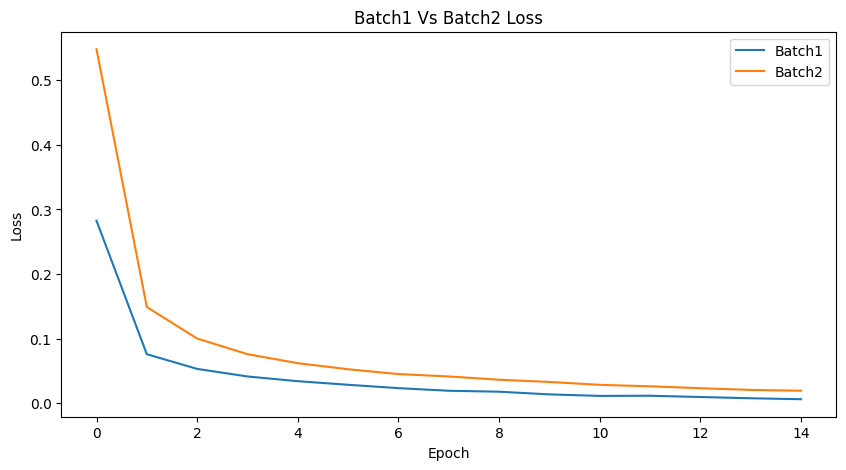

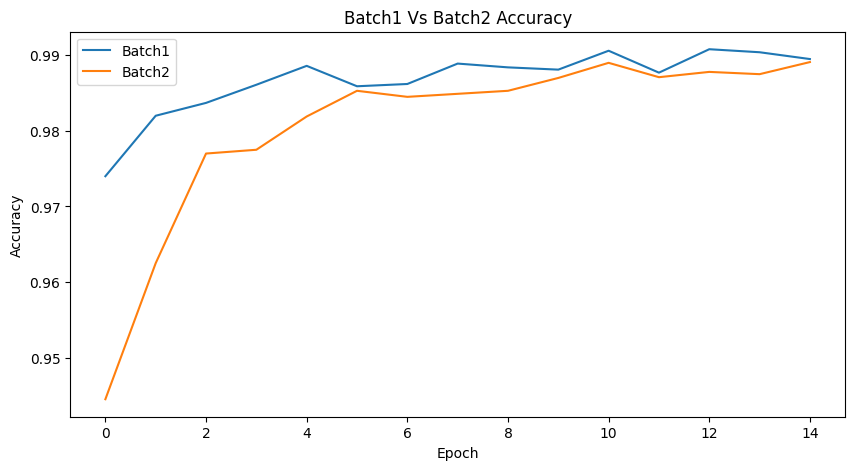

In [15]:
#plotting epoch vs loss
pt.figure(figsize=(10,5))
pt.plot(np.arange(0,15), batch1_train_loss)
pt.plot(np.arange(0,15), batch2_train_loss)
pt.title('Batch1 Vs Batch2 Loss')
pt.xlabel('Epoch')
pt.ylabel('Loss')
pt.legend(['Batch1', 'Batch2'])
pt.show()

#plotting epoch vs accuracy
pt.figure(figsize=(10,5))
pt.plot(np.arange(0,15), batch1_test_acc)
pt.plot(np.arange(0,15), batch2_test_acc)
pt.title('Batch1 Vs Batch2 Accuracy')
pt.xlabel('Epoch')
pt.ylabel('Accuracy')
pt.legend(['Batch1', 'Batch2'])
pt.show()

In [16]:
def compute_metrics(model, trainloader, testloader):
    correct_train = 0
    total_train = 0
    train_cost_sum = 0
    train_cost_counter = 0
    with torch.no_grad():
        for i,j in trainloader:
            predicted_output = model(i)
            fn = loss_function(predicted_output, j)
            train_cost_sum += fn
            train_cost_counter += 1
            correct_train += (torch.argmax(predicted_output, dim=1) == j).sum().item()
            total_train += j.size(0)
    train_loss = train_cost_sum / train_cost_counter
    train_acc = round(correct_train / total_train, 3)
    
    correct_test = 0
    total_test = 0
    test_cost_sum = 0
    test_cost_counter = 0
    with torch.no_grad():
        for i,j in testloader:
            predicted_output = model(i)
            fn = loss_function(predicted_output, j)
            test_cost_sum += fn
            test_cost_counter += 1
            correct_test += (torch.argmax(predicted_output, dim=1) == j).sum().item()
            total_test += j.size(0)
    test_loss = test_cost_sum / test_cost_counter
    test_acc = round(correct_test / total_test, 3)
    
    return train_loss, train_acc, test_loss, test_acc

In [19]:
#performing interpolation between two set of batches datasets

alpha = np.linspace(0, 20, num = 100)
theta = []
theta = (1 - alpha[:, np.newaxis]) * batch1_params.detach().numpy() + alpha[:, np.newaxis] * batch2_params.detach().numpy()
i = 0

train_losses_arr, train_acc_arr, test_losses_arr, test_acc_arr = [], [], [], [] 
while i < len(theta):
    theta_c = (1 - alpha[i]) * batch1_params + alpha[i] * batch2_params
    model = Model_1()
    
    #set parameters to interpolated theta
    torch.nn.utils.vector_to_parameters(theta_c, model.parameters())
    
    arr = [torch.numel(param) for param in model.parameters()]
    
    #check on this, we used train and test loader of batch1 here. Is it correct?
    train_loss, train_acc, test_loss, test_acc = compute_metrics(model, train_loader_1, test_loader_1)
    train_losses_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    test_losses_arr.append(test_loss)
    test_acc_arr.append(test_acc)
    i+=1

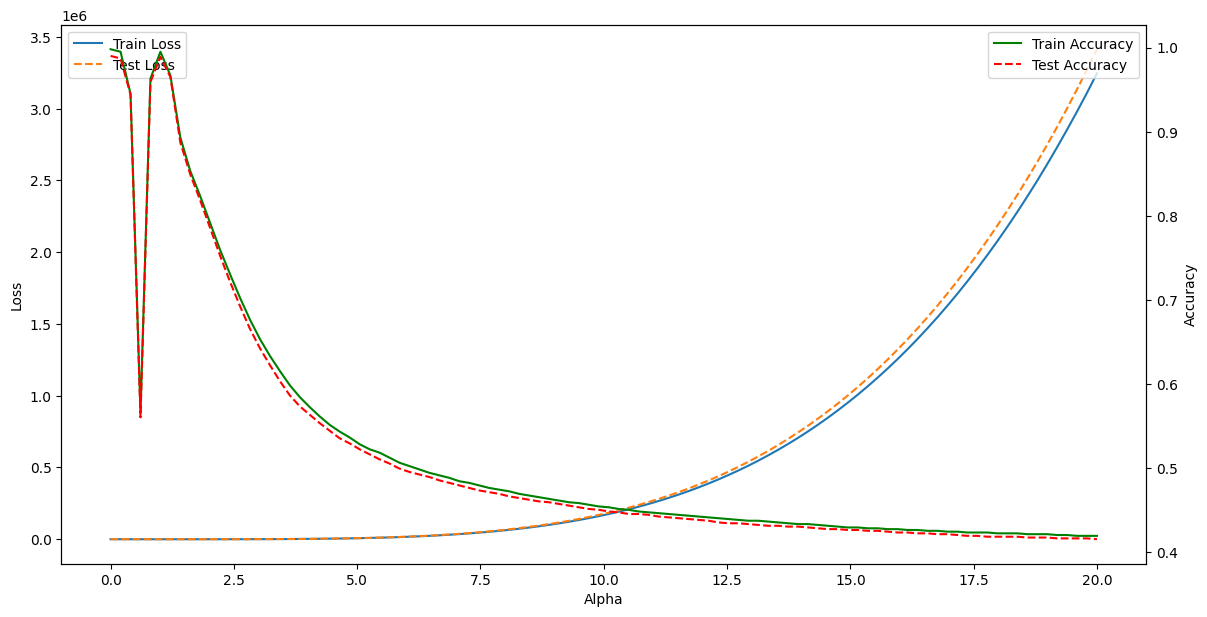

In [22]:
pt.figure(figsize=(14,7))
pt.plot(alpha[:100], train_losses_arr[:100])
pt.plot(alpha[:100], test_losses_arr[:100], linestyle='--')
pt.xlabel('Alpha')
pt.ylabel('Loss')
pt.legend(['Train Loss', 'Test Loss'])

pt.twinx()

pt.plot(alpha[:100], train_acc_arr[:100], color="green")
pt.plot(alpha[:100], test_acc_arr[:100], linestyle='--', color="red")
pt.xlabel('Alpha')
pt.ylabel('Accuracy')
pt.legend(['Train Accuracy', 'Test Accuracy'])

pt.show()